In [1]:
import os
import xarray as xr
import cfgrib
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## Filter to Surface Level

In [16]:
ds = xr.open_dataset('../data/narr-a_221_19790108_0000_000.grb',engine='cfgrib',filter_by_keys={'stepType':'instant','typeOfLevel': 'surface'},backend_kwargs={'errors': 'ignore'})

Ignoring index file '../data/narr-a_221_19790108_0000_000.grb.5b7b6.idx' incompatible with GRIB file


In [12]:
print(ds)

<xarray.Dataset> Size: 24MB
Dimensions:        (isobaricInhPa: 29, y: 277, x: 349)
Coordinates:
    time           datetime64[ns] 8B ...
    step           timedelta64[ns] 8B ...
  * isobaricInhPa  (isobaricInhPa) float64 232B 1e+03 975.0 ... 125.0 100.0
    latitude       (y, x) float64 773kB ...
    longitude      (y, x) float64 773kB ...
    valid_time     datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    tpag10         (isobaricInhPa, y, x) float32 11MB ...
    unknown        (isobaricInhPa, y, x) float32 11MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          15
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-09-25T10:31 GRIB to CDM+CF via cfgrib-0.9.1...


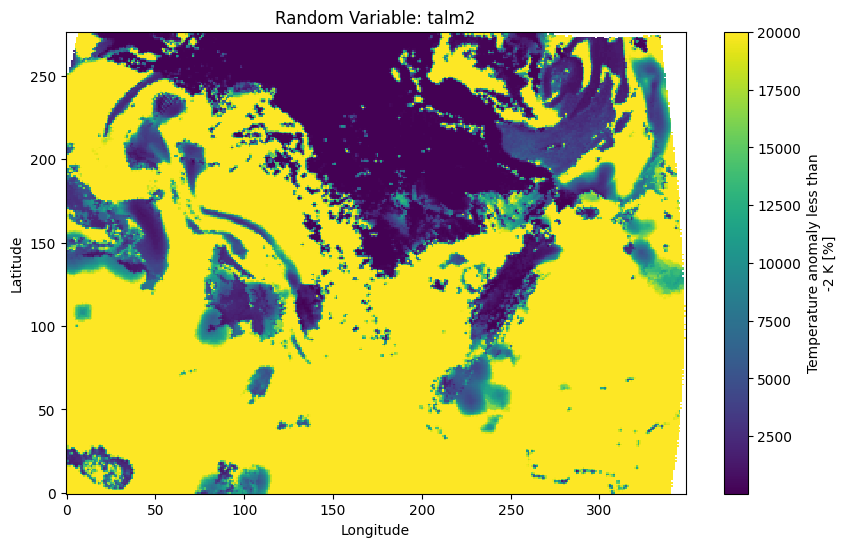

In [7]:
data = ds['talm2']

plt.figure(figsize=(10, 6))
data.plot(cmap='viridis')
plt.title('Random Variable: talm2')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Filter by Isobaric Pressure 

In [14]:
ds = xr.open_dataset('../data/narr-a_221_19790108_0000_000.grb',engine='cfgrib',backend_kwargs={'errors': 'ignore','filter_by_keys': {'typeOfLevel': 'isobaricInhPa'}})

Ignoring index file '../data/narr-a_221_19790108_0000_000.grb.5b7b6.idx' incompatible with GRIB file


In [ ]:
print(ds)

In [2]:
globfire = gpd.read_file('/Users/eliotcarlson/Desktop/columbia/capstone/data/globfire/original_globfire_filtered_2002.shp')

In [6]:
western_us_bounds = {
    "min_longitude": -125,
    "max_longitude": -100,
    "min_latitude": 32,
    "max_latitude": 49
}

# Filter the GeoDataFrame using cx (for geographic coordinates)
west = globfire.to_crs(epsg=4326).cx[
    western_us_bounds["min_longitude"]:western_us_bounds["max_longitude"],
    western_us_bounds["min_latitude"]:western_us_bounds["max_latitude"]
]

# Now gdf_western_us contains only the geometries in the Western US.
print(west)

             _uid_         id initialdat  finaldate     area_ha  \
15            16.0   966855.0 2002-01-08 2002-01-08   21.467432   
16            17.0   966856.0 2002-01-10 2002-01-10  279.078281   
17            18.0   966858.0 2002-01-11 2002-01-14  364.862618   
18            19.0   966859.0 2002-01-08 2002-01-15  171.639568   
45797      45798.0   966857.0 2002-01-17 2002-01-17  193.206072   
...            ...        ...        ...        ...         ...   
1015404  1015405.0  2028456.0 2002-12-13 2002-12-24  925.257974   
1015405  1015406.0  2028458.0 2002-12-19 2002-12-19   21.517385   
1015406  1015407.0  2028461.0 2002-12-17 2002-12-19  107.577722   
1015407  1015408.0  2028463.0 2002-12-19 2002-12-19   21.511081   
1015409  1015410.0  2028465.0 2002-12-27 2002-12-31  989.359223   

                                                  geometry  
15       POLYGON ((-119.73509 35.65, -119.72997 35.65, ...  
16       MULTIPOLYGON (((-119.73174 35.6375, -119.72149...  
17       MUL

(32.0, 49.0)

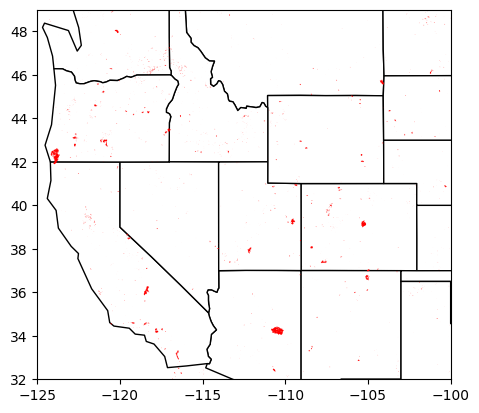

In [18]:
states = gpd.read_file('/Users/eliotcarlson/Downloads/state_borders/ne_110m_admin_1_states_provinces.shp')

ax = states.plot(color='white', edgecolor='black')

west.plot(ax=ax,color="red",markersize = west["area_ha"]/np.max(west["area_ha"]))
ax.set_xlim([-125,-100])
ax.set_ylim([32,49])

In [25]:
for var_name, var_data in ds.data_vars.items():
    print(f"{var_name} dimensions: {var_data.dims}")
    print(f"{var_name} coordinates: {list(var_data.coords)}")

talm2 dimensions: ('y', 'x')
talm2 coordinates: ['time', 'step', 'surface', 'latitude', 'longitude', 'valid_time']
t2ag2 dimensions: ('y', 'x')
t2ag2 coordinates: ['time', 'step', 'surface', 'latitude', 'longitude', 'valid_time']
tprl1 dimensions: ('y', 'x')
tprl1 coordinates: ['time', 'step', 'surface', 'latitude', 'longitude', 'valid_time']
tprg3 dimensions: ('y', 'x')
tprg3 coordinates: ['time', 'step', 'surface', 'latitude', 'longitude', 'valid_time']
tpg200 dimensions: ('y', 'x')
tpg200 coordinates: ['time', 'step', 'surface', 'latitude', 'longitude', 'valid_time']
tpg80 dimensions: ('y', 'x')
tpg80 coordinates: ['time', 'step', 'surface', 'latitude', 'longitude', 'valid_time']
